In [1]:
import os
import glob
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



# 数据预处理

In [2]:
def is_left_file(filename):
    return os.path.basename(filename).startswith("L")

def find_all_zero_columns(folder):
    files = glob.glob(os.path.join(folder, '*_trajectory.csv'))
    all_zero_cols = set()

    for file in files:
        is_left = is_left_file(file)
        prefix = 'L' if is_left else 'R'

        df = pd.read_csv(file)
        relevant_cols = [col for col in df.columns if col.startswith(prefix)]

        df_subset = df[relevant_cols]
        zero_cols = df_subset.columns[(df_subset == 0).all()].tolist()
        all_zero_cols.update(zero_cols)

    return all_zero_cols

train_zero_cols = find_all_zero_columns('random_dataset/train')
val_zero_cols = find_all_zero_columns('random_dataset/val')
merged_zero_cols = sorted(train_zero_cols.union(val_zero_cols))

print("Markers with all zero:")
print(', '.join(merged_zero_cols))

# remove L(R)KNM, L(R)MED, L(R)SHO, L(R)SMH

Markers with all zero:
LKNM_X, LKNM_X', LKNM_X'', LKNM_Y, LKNM_Y', LKNM_Y'', LKNM_Z, LKNM_Z', LKNM_Z'', LMED_X, LMED_X', LMED_X'', LMED_Y, LMED_Y', LMED_Y'', LMED_Z, LMED_Z', LMED_Z'', LSMH_X, LSMH_X', LSMH_X'', LSMH_Y, LSMH_Y', LSMH_Y'', LSMH_Z, LSMH_Z', LSMH_Z'', RKNM_X, RKNM_X', RKNM_X'', RKNM_Y, RKNM_Y', RKNM_Y'', RKNM_Z, RKNM_Z', RKNM_Z'', RMED_X, RMED_X', RMED_X'', RMED_Y, RMED_Y', RMED_Y'', RMED_Z, RMED_Z', RMED_Z'', RSHO_X, RSHO_X', RSHO_X'', RSHO_Y, RSHO_Y', RSHO_Y'', RSHO_Z, RSHO_Z', RSHO_Z'', RSMH_X, RSMH_X', RSMH_X'', RSMH_Y, RSMH_Y', RSMH_Y'', RSMH_Z, RSMH_Z', RSMH_Z''


In [3]:

# ========== Data Loading Functions ==========
EXCLUDED_POINTS = ['LFHD', 'RFHD', 'LBHD', 'RBHD', 'C7', 'T10', 'CLAV', 'RBAK']
NUM_FEATURES = 9
FIXED_POINTS = ['LANK', 'LHEE', 'LKNE', 'LTOE', 'LTHI', 'LTIAD', 'LTIAP', 'LTIB', 'LTHAD', 'LTHAP', 'LPSI', 'LASI', 'LFMH', 'LVMH', 
                'RANK', 'RHEE', 'RKNE', 'RTOE', 'RTHI', 'RTIAD', 'RTIAP', 'RTIB', 'RTHAD', 'RTHAP', 'RPSI', 'RASI', 'RFMH', 'RVMH']

def is_left_file(filename):
    return os.path.basename(filename).startswith("L")

def pair_files(folder_path):
    traj_files = sorted(glob.glob(os.path.join(folder_path, '*_trajectory.csv')))
    model_files = sorted(glob.glob(os.path.join(folder_path, '*_model.csv')))
    pairs = []
    for traj in traj_files:
        base = os.path.basename(traj).replace('_trajectory.csv', '')
        model = os.path.join(folder_path, base + '_model.csv')
        if os.path.exists(model):
            pairs.append((traj, model))
    return pairs

def read_trajectory(traj_path, is_left, selected_markers=None):
    df = pd.read_csv(traj_path)
    suffixes = ['X', 'Y', 'Z', "X'", "Y'", "Z'", "X''", "Y''", "Z''"]
    prefix = 'L' if is_left else 'R'

    if selected_markers is not None:
        point_list = [f"{prefix}{m}" for m in selected_markers]
    else:
        point_list = [p for p in FIXED_POINTS if p.startswith(prefix)]

    cols = [f"{p}_{s}" for p in point_list for s in suffixes if f"{p}_{s}" in df.columns]
    X = df[cols].values.reshape(-1, len(point_list), NUM_FEATURES)
    return X

def read_kam(model_path, is_left):
    df = pd.read_csv(model_path)
    col = 'LKneeMoment_Y' if is_left else 'RKneeMoment_Y'
    return df[col].values

# ========== Dataset Class ==========

class KAMDataset(torch.utils.data.Dataset):
    def __init__(self, folder_path, selected_markers=None):
        self.data = []
        pairs = pair_files(folder_path)

        for traj_path, model_path in pairs:
            is_left = is_left_file(traj_path)

            X = read_trajectory(traj_path, is_left, selected_markers)
            Y = read_kam(model_path, is_left)

            input_tensor = torch.tensor(X, dtype=torch.float32)
            target_tensor = torch.tensor(Y, dtype=torch.float32)
            filename = os.path.basename(model_path)

            self.data.append({
                'input': input_tensor,
                'target': target_tensor,
                'filename': filename
            })

        self.selected_markers = selected_markers
        print(f"Loaded {len(self.data)} samples (using {X.shape[1]} markers)")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# ========== collate_fn ==========

def collate_fn(batch):
    inputs = [item['input'] for item in batch]
    targets = [item['target'] for item in batch]
    lengths = [x.shape[0] for x in inputs]
    max_len = max(lengths)

    padded_inputs = pad_sequence(inputs, batch_first=True)  # (B, T, N, D)
    padded_targets = pad_sequence([y.unsqueeze(-1) for y in targets], batch_first=True).squeeze(-1)  # (B, T)

    mask = torch.zeros((len(batch), max_len), dtype=torch.bool)
    for i, l in enumerate(lengths):
        mask[i, :l] = 1

    return padded_inputs, padded_targets, mask

# ========== Model Definitions ==========
class PointNetEncoder(nn.Module):
    def __init__(self, channel=9):
        super().__init__()
            self.conv1 = nn.Conv2d(channel, 64, kernel_size=(1, 1))
            self.bn1 = nn.BatchNorm2d(64)
            self.conv2 = nn.Conv2d(64, 128, kernel_size=(1, 1))
            self.bn2 = nn.BatchNorm2d(128)

    def forward(self, x):  # x: [B*T, C, N]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = torch.max(x, 2, keepdim=False)[0]  # [B*T, 128]
        return x


class BiLSTM(nn.Module):
    def __init__(self, input_size=128, hidden_size=96, num_layers=3, output_size=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers,
                            batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x, mask):  # x: [B, T, F], mask: [B, T]
        out, _ = self.lstm(x)             # [B, T, 2*hidden]
        out = self.fc(out).squeeze(-1)    # [B, T]
        return out * mask                 # 避免pad位置参与loss计算


class PointNetBiLSTMRegressor(nn.Module):
    def __init__(self, input_dim=9, hidden_dim=128, lstm_hidden=96, lstm_layers=3):
        super().__init__()
        self.encoder = PointNetEncoder(channel=input_dim)
        self.lstm = BiLSTM(input_size=hidden_dim, hidden_size=lstm_hidden, num_layers=lstm_layers, output_size=1)

    def forward(self, x, mask):  # x: [B, T, N, D], mask: [B, T]
        B, T, N, D = x.shape
        x = x.permute(0, 1, 3, 2).reshape(B * T, D, N)  # → [B*T, D, N]
        feat = self.encoder(x)  # → [B*T, 128]
        feat = feat.view(B, T, -1)  # → [B, T, 128]
        out = self.lstm(feat, mask)  # → [B, T]
        return out


# ========== Loss Function ==========

def masked_mse_loss(pred, target, mask):
    loss = F.mse_loss(pred, target, reduction='none')
    return (loss * mask).sum() / mask.sum()

# ========== Training Function ==========

def train_model(model, train_loader, val_loader, epochs=500, lr=1e-3, patience=50, save_path='best_model2.pth'):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_loss = float('inf')
    patience_counter = 0
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for x, y, m in train_loader:
            x = x.to(device)
            y = y.to(device)
            m = m.to(device)
            pred = model(x, m)
            loss = masked_mse_loss(pred, y, m)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for x, y, m in val_loader:
                x = x.to(device)
                y = y.to(device)
                m = m.to(device)
                pred = model(x, m)
                loss = masked_mse_loss(pred, y, m)
                total_val_loss += loss.item()

        train_loss = total_train_loss / len(train_loader)
        val_loss = total_val_loss / len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), save_path)
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curve')
    plt.savefig('loss_curve.png')
    plt.close()

# ========== Evaluation Function ==========

def evaluate_model(model, test_loader, save_dir='results'):
    os.makedirs(save_dir, exist_ok=True)
    model.eval()
    total_mse, total_frames = 0, 0

    with torch.no_grad():
        for i, (x, y, m) in enumerate(test_loader):
            x = x.to(device)
            y = y.to(device)
            m = m.to(device)
            pred = model(x, m)
            for b in range(x.size(0)):
                T = int(m[b].sum().item())
                gt = y[b][:T].cpu().numpy()
                pr = pred[b][:T].cpu().numpy()
                mse = np.mean((gt - pr) ** 2)
                total_mse += mse * T
                total_frames += T

                plt.figure()
                plt.plot(gt, label='GT')
                plt.plot(pr, label='Pred')
                plt.xlabel('Frame')
                plt.ylabel('KAM')
                plt.title(f'Sample {i*test_loader.batch_size + b}, MSE: {mse:.4f}')
                plt.legend()
                plt.savefig(os.path.join(save_dir, f'sample_{i*test_loader.batch_size + b}.png'))
                plt.close()

    avg_mse = total_mse / total_frames
    print(f"Test MSE: {avg_mse:.6f}")

# ========== Reproducibility ==========

def set_seed(seed=5703):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.use_deterministic_algorithms(True)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [4]:
def compute_saliency_map_symmetric(model, dataloader, device='cuda', num_samples=2000):
    model = model.to(device)
    model.train()
    saliency_accum = None
    total_valid_frames = 0

    for x, y, m in dataloader:
        if total_valid_frames >= num_samples:
            break

        x = x.to(device).detach().requires_grad_(True)  # (B, T, N, D)
        m = m.to(device)  # (B, T)

        output = model(x, m)  # (B, T)
        loss = output.sum()
        loss.backward()

        grad = x.grad.detach()  # (B, T, N, D)

        # Expand mask: (B, T, 1, 1) → broadcast to (B, T, N, D)
        mask_expanded = m.unsqueeze(-1).unsqueeze(-1).float()
        grad = grad * mask_expanded  # 屏蔽掉 padding 帧的梯度

        grad_abs = grad.abs()
        grad_sum = grad_abs.sum(dim=(1, 3))  # sum over T and D → shape: (B, N)

        if saliency_accum is None:
            saliency_accum = grad_sum.sum(dim=0)  # shape: (N,)
        else:
            saliency_accum += grad_sum.sum(dim=0)

        total_valid_frames += m.sum().item()  # 累计有效帧数（不是样本数）

    # Normalize saliency by total valid frames, not total samples
    saliency = saliency_accum.cpu().numpy() / total_valid_frames
    saliency = saliency / saliency.sum()  # normalize to sum 1

    # === Merge L/R marker saliency by symmetric name ===
    N = saliency.shape[0]

    left_markers = [p for p in FIXED_POINTS if p.startswith('L')]
    right_markers = [p for p in FIXED_POINTS if p.startswith('R')]

    if N == len(left_markers):
        marker_names = left_markers
    elif N == len(right_markers):
        marker_names = right_markers
    else:
        raise ValueError("Unable to determine marker side.")

    suffix_dict = {}
    for name, value in zip(marker_names, saliency):
        suffix = name[1:]  # remove L/R
        suffix_dict.setdefault(suffix, []).append(value)

    merged_saliency = {k: np.mean(v) for k, v in suffix_dict.items()}
    return merged_saliency


# 加载数据，初始化模型

In [5]:
set_seed(5703)

# Load dataset splits
train_set = KAMDataset(os.path.join('random_dataset', 'train'))
val_set = KAMDataset(os.path.join('random_dataset', 'val'))
test_set = KAMDataset(os.path.join('random_dataset', 'test'))

print(f"Training samples: {len(train_set)}, Validation samples: {len(val_set)}, Test samples: {len(test_set)}")

# Create DataLoaders
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False, collate_fn=collate_fn)

# Train baseline model using all markers
model = PointNetBiLSTMRegressor().to(device)
print(f"Model is running on: {next(model.parameters()).device}")
train_model(model, train_loader, val_loader, save_path='baseline_all_marker2.pth')


Loaded 2336 samples (using 14 markers)
Loaded 292 samples (using 14 markers)
Loaded 292 samples (using 14 markers)
Training samples: 2336, Validation samples: 292, Test samples: 292
Model is running on: cuda:0
Epoch 1, Train Loss: 3.4697, Val Loss: 2.7765
Epoch 2, Train Loss: 2.1722, Val Loss: 2.3617
Epoch 3, Train Loss: 1.7730, Val Loss: 1.9292
Epoch 4, Train Loss: 1.6029, Val Loss: 1.8293
Epoch 5, Train Loss: 1.3538, Val Loss: 1.7553
Epoch 6, Train Loss: 1.2731, Val Loss: 1.4479
Epoch 7, Train Loss: 1.2024, Val Loss: 1.4310
Epoch 8, Train Loss: 1.0567, Val Loss: 1.3838
Epoch 9, Train Loss: 1.0359, Val Loss: 1.3523
Epoch 10, Train Loss: 0.9909, Val Loss: 1.0920
Epoch 11, Train Loss: 0.8509, Val Loss: 1.1191
Epoch 12, Train Loss: 0.8589, Val Loss: 1.0060
Epoch 13, Train Loss: 0.8120, Val Loss: 0.9927
Epoch 14, Train Loss: 0.7713, Val Loss: 0.9316
Epoch 15, Train Loss: 0.7153, Val Loss: 0.8986
Epoch 16, Train Loss: 0.6665, Val Loss: 1.3563
Epoch 17, Train Loss: 0.8039, Val Loss: 1.0548


# 计算marker重要性

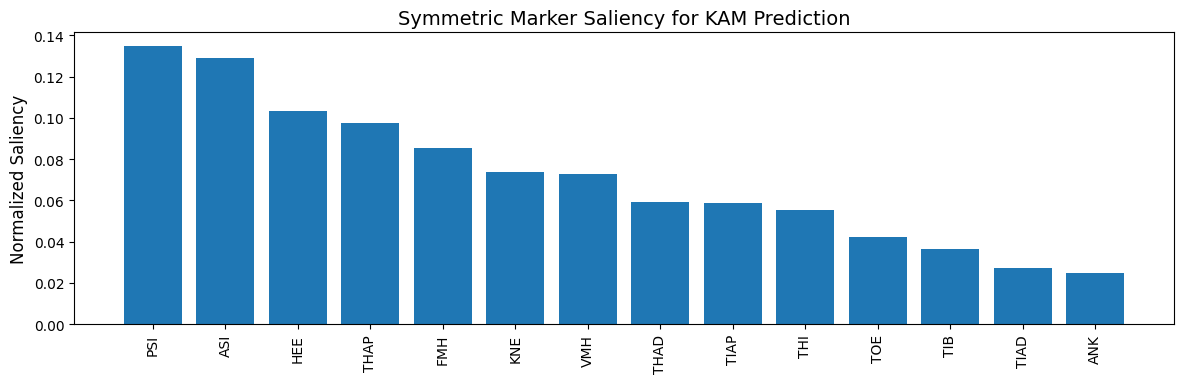

Top influential symmetric markers:
PSI: 0.1347
ASI: 0.1290
HEE: 0.1031
THAP: 0.0977
FMH: 0.0852
KNE: 0.0739
VMH: 0.0726
THAD: 0.0593
TIAP: 0.0588
THI: 0.0553


In [6]:
# ---- Step 1: 固定随机性 ----
set_seed(5703)

# ---- Step 2: matplotlib 也保持一致 ----
import matplotlib.pyplot as plt

plt.rcParams.update({
    'figure.dpi': 100,
    'savefig.dpi': 100,
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.figsize': (12, 4),
})

# ---- Step 3: 计算 saliency map ----
model.load_state_dict(torch.load('baseline_all_marker2.pth'))
model.eval()
merged_saliency = compute_saliency_map_symmetric(model, val_loader, device=device)

# ---- Step 4: 可视化 ----
sorted_items = sorted(merged_saliency.items(), key=lambda x: -x[1])
labels, values = zip(*sorted_items)

plt.figure()
plt.bar(labels, values, color='tab:blue')  # 固定颜色（可选）
plt.xticks(rotation=90)
plt.ylabel("Normalized Saliency")
plt.title("Symmetric Marker Saliency for KAM Prediction")
plt.tight_layout()
plt.savefig("merged_saliency.png")
plt.show()


# Print the top 10 most influential symmetric markers
print("Top influential symmetric markers:")
for name, score in sorted_items[:10]:
    print(f"{name}: {score:.4f}")


# marker筛选

In [7]:
def evaluate_marker_combinations(
    saliency_dict,
    top_k_list,
    root_dir='random_dataset',
    epochs=500,
    patience=50,
    all_marker_result=None,
    final_model_path='best_marker_combination2.pth'
):
    """
    Evaluate model performance with different top-k marker subsets selected by saliency.

    Args:
        saliency_dict (dict): Symmetric saliency scores, e.g., {'ANK': 0.12, ...}
        top_k_list (list): List of k values for top-k marker selection, e.g., [4, 6, 11]
        root_dir (str): Path to dataset root folder containing 'train' and 'val'
        epochs (int): Maximum number of training epochs
        patience (int): Early stopping patience
        all_marker_result (float or None): Optional val loss of all-marker model for comparison
        final_model_path (str): Path to save the best-performing model

    Returns:
        results (list): List of tuples (Top-k name, selected suffixes, val loss)
    """
    results = []
    sorted_markers = sorted(saliency_dict.items(), key=lambda x: -x[1])
    best_model_file = None

    for k in top_k_list:
        selected_suffixes = [name for name, _ in sorted_markers[:k]]
        print(f"\n Training with Top-{k} markers: {selected_suffixes}")

        # Prepare datasets and loaders
        train_set = KAMDataset(os.path.join(root_dir, 'train'), selected_suffixes)
        val_set = KAMDataset(os.path.join(root_dir, 'val'), selected_suffixes)

        train_loader = DataLoader(train_set, batch_size=64, shuffle=True, collate_fn=collate_fn)
        val_loader = DataLoader(val_set, batch_size=64, shuffle=False, collate_fn=collate_fn)

        # Train model
        model = PointNetBiLSTMRegressor()
        model_save_path = f"CNN_LSTM_top_{k}.pth"
        train_model(model, train_loader, val_loader, epochs=epochs, patience=patience, save_path=model_save_path)
        model.load_state_dict(torch.load(model_save_path))

        # Evaluate on validation set
        model.eval()
        total_val_loss = 0
        total_count = 0
        with torch.no_grad():
            for x, y, m in val_loader:
                x = x.to(device)
                y = y.to(device)
                m = m.to(device)
                pred = model(x, m)
                loss = masked_mse_loss(pred, y, m)
                total_val_loss += loss.item() * x.size(0)
                total_count += x.size(0)

        avg_val_loss = total_val_loss / total_count
        results.append((f"Top-{k}", selected_suffixes, avg_val_loss))
        print(f"Top-{k} markers Val Loss: {avg_val_loss:.6f}")

        # Track best model path
        if best_model_file is None or avg_val_loss < min([r[2] for r in results[:-1]]):
            best_model_file = model_save_path

    # Add all-marker baseline result (if provided)
    if all_marker_result is not None:
        results.append(("All", "All markers", all_marker_result))
        print(f"\n Included all markers baseline Val Loss: {all_marker_result:.6f}")

    # Report best result
    best = min(results, key=lambda x: x[2])
    print("\n Best marker combination:")
    print(f"{best[0]} markers: {best[1]}")
    print(f"Val Loss: {best[2]:.6f}")

    # Save best model
    if best_model_file is not None:
        import shutil
        shutil.copyfile(best_model_file, final_model_path)
        print(f" Best model saved to: {final_model_path}")

    return results, best[1]


In [8]:
# Step 0: 固定随机性
set_seed(5703)

# Step 1: 评估 + 选最优模型
results, best_markers = evaluate_marker_combinations(
    merged_saliency,
    top_k_list=[4, 5, 7, 10, 12, 14],
    all_marker_result=None,
    final_model_path='best_marker_combination2.pth'
)

# Step 2: 测试阶段加载最佳模型
model = PointNetBiLSTMRegressor().to(device)
model.load_state_dict(torch.load('best_marker_combination2.pth', map_location=device))
model.eval()  # ✅ 加这句

test_set = KAMDataset('random_dataset/test', selected_markers=best_markers)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, collate_fn=collate_fn)

# Step 3: 测试评估
evaluate_model(model, test_loader)



 Training with Top-4 markers: ['PSI', 'ASI', 'HEE', 'THAP']
Loaded 2336 samples (using 4 markers)
Loaded 292 samples (using 4 markers)
Epoch 1, Train Loss: 3.4056, Val Loss: 2.6427
Epoch 2, Train Loss: 2.0669, Val Loss: 2.4815
Epoch 3, Train Loss: 1.8290, Val Loss: 2.3906
Epoch 4, Train Loss: 1.5635, Val Loss: 1.7551
Epoch 5, Train Loss: 1.4366, Val Loss: 1.6123
Epoch 6, Train Loss: 1.3006, Val Loss: 1.4447
Epoch 7, Train Loss: 1.1976, Val Loss: 1.4879
Epoch 8, Train Loss: 1.1388, Val Loss: 1.6034
Epoch 9, Train Loss: 1.0182, Val Loss: 1.8576
Epoch 10, Train Loss: 1.0557, Val Loss: 1.1081
Epoch 11, Train Loss: 0.9351, Val Loss: 1.1275
Epoch 12, Train Loss: 0.8700, Val Loss: 1.0447
Epoch 13, Train Loss: 0.8691, Val Loss: 1.5034
Epoch 14, Train Loss: 0.8884, Val Loss: 1.0430
Epoch 15, Train Loss: 0.7924, Val Loss: 0.9227
Epoch 16, Train Loss: 0.6856, Val Loss: 0.8669
Epoch 17, Train Loss: 0.6107, Val Loss: 0.9498
Epoch 18, Train Loss: 0.7212, Val Loss: 0.8818
Epoch 19, Train Loss: 0.672

In [9]:
def plot_average_kam_curve(model, dataset, device='cuda', save_path=None, show=True):
    import matplotlib.pyplot as plt

    model = model.to(device)
    model.eval()

    all_true = []
    all_pred = []

    max_length = 0
    for idx in range(len(dataset)):
        sample = dataset[idx]
        x = sample['input'].unsqueeze(0).to(device)
        y = sample['target'].unsqueeze(0).to(device)
        T = x.shape[1]
        mask = torch.ones((1, T), dtype=torch.bool).to(device)

        with torch.no_grad():
            pred = model(x, mask)

        true_kam = y.squeeze(0).cpu().numpy()
        pred_kam = pred.squeeze(0).cpu().numpy()
        length = min(len(true_kam), len(pred_kam))
        max_length = max(max_length, length)

        all_true.append(true_kam[:length])
        all_pred.append(pred_kam[:length])

    # Pad with NaN to max_length
    def pad_with_nan(seq_list, max_len):
        return np.array([
            np.pad(seq, (0, max_len - len(seq)), constant_values=np.nan)
            for seq in seq_list
        ])

    all_true_padded = pad_with_nan(all_true, max_length)
    all_pred_padded = pad_with_nan(all_pred, max_length)

    # Compute mean over valid (non-NaN) values
    mean_true_curve = np.nanmean(all_true_padded, axis=0)
    mean_pred_curve = np.nanmean(all_pred_padded, axis=0)

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(mean_true_curve, label='Mean Ground Truth', linewidth=2)
    plt.plot(mean_pred_curve, label='Mean Prediction', linestyle='--')
    plt.xlabel('Frame')
    plt.ylabel('KAM')
    plt.title('Mean KAM Curve Across All Samples')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        plt.close()
    elif show:
        plt.show()


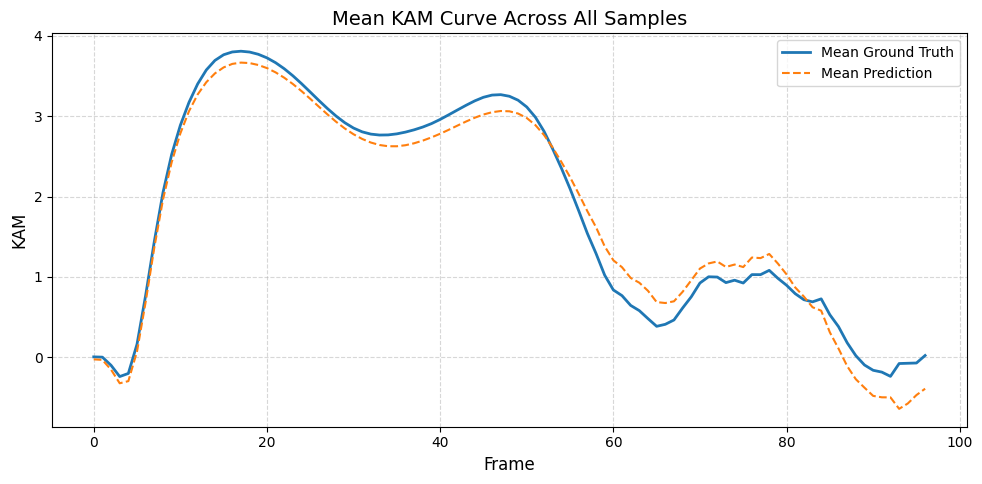

In [10]:
plot_average_kam_curve(model, test_set, device='cuda')


In [11]:
def extract_peak_kam_metrics(model, dataset, save_csv_path='results/peak_kam_summary.csv', device=device):
    model = model.to(device)
    model.eval()
    records = []

    for idx in range(len(dataset)):
        sample = dataset[idx]
        x = sample['input'].unsqueeze(0).to(device)      # (1, T, N, D)
        y = sample['target'].unsqueeze(0).to(device)     # (1, T)
        T = x.shape[1]
        mask = torch.ones((1, T), dtype=torch.bool).to(device)
        filename = sample['filename']

        with torch.no_grad():
            pred = model(x, mask)  # (1, T)

        pred_kam = pred.squeeze(0).cpu().numpy()
        true_kam = y.squeeze(0).cpu().numpy()

        mid = T // 2
        true_kam1 = np.max(true_kam[:mid]) if mid > 0 else np.nan
        true_kam2 = np.max(true_kam[mid:]) if mid < T else np.nan
        pred_kam1 = np.max(pred_kam[:mid]) if mid > 0 else np.nan
        pred_kam2 = np.max(pred_kam[mid:]) if mid < T else np.nan

        records.append({
            'n': filename,
            'peak KAM1 Actual': true_kam1,
            'peak KAM1 Predict': pred_kam1,
            'peak KAM2 Actual': true_kam2,
            'peak KAM2 Predict': pred_kam2,
        })

    df = pd.DataFrame(records)
    df.to_csv(save_csv_path, index=False)
    print(f"{save_csv_path}")
    return df


In [12]:
from numpy import mean, std

df = extract_peak_kam_metrics(model, test_set, device=device)

kam1_mse = mean((df['peak KAM1 Actual'] - df['peak KAM1 Predict'])**2)
kam2_mse = mean((df['peak KAM2 Actual'] - df['peak KAM2 Predict'])**2)

print(f"Peak KAM1 MSE  → Mean = {kam1_mse:.6f}")
print(f"Peak KAM2 MSE  → Mean = {kam2_mse:.6f}")

results/peak_kam_summary.csv
Peak KAM1 MSE  → Mean = 1.053954
Peak KAM2 MSE  → Mean = 0.910575
